# SFML Project

Ward Gauderis - 0588485
Fabian Denoodt - TODO

Master Computer Science in Artificial Intelligence - Vrije Universiteit Brussel

## Introduction

1. What is the influence of stochastic noise in the dataset on the in- and out-of-sample error and how does regularisation counter this?
2. b
3. c

## Research Question 1

Data noise & label noise

#### Initialization

In [110]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

cmap = plt.cm.RdBu_r


def scales(ax: plt.Axes) -> None:
    """
    Helper function to configure the axes
    :param ax: plot axes
    :return: None
    """
    x_min = -2
    x_max = 2
    y_min = -2
    y_max = 2

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("equal")

    return x_min, x_max, y_min, y_max


def plot_points(X: np.ndarray, y: np.ndarray, ax: plt.Axes) -> None:
    """
    Make a scatter plot of the points and their label
    :param X: features
    :param y: labels
    :param ax: plot axes
    :return: None
    """
    scales(X, ax)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=20)


def plot_decision_boundaries(X, y, ax: plt.Axes, model: Pipeline, resolution=0.02, decision=False) -> plt.Axes:
    """
    Plot the decision boundary of a sklearn model together with the data points
    :param X: features
    :param y: labels
    :param ax: plot axes
    :param model: sklearn model
    :param resolution: resolution of the contour plot
    :param decision: plot decisions or probabilities
    :return: ax
    """
    x_min, x_max, y_min, y_max = scales(X, ax)

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    if decision:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    else:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap=cmap, s=10)

    return ax

In [112]:
def make_datasets(moons: bool, data_noise: bool, label_noise: bool, min_noise: float, max_noise: float,
                  dataset_size: int, N: int) -> (
        list[(np.ndarray, np.ndarray)], np.ndarray):
    """
    Make N synthetic data sets ranging in noise value
    :param moons: make two moon shape classes of points or make two contained circular classes of points
    :param data_noise: Add Gaussian data noise to the features
    :param label_noise: Add label noise by swapping a percentage of labels
    :param min_noise: minimum noise value >= 0
    :param max_noise: maximum noise value >= 0
    :param dataset_size: amount of data points
    :param N: Amount of datasets to generate
    :return: A list of datasets and an array of noise values
    """
    datasets = []

    noises = np.linspace(min_noise, max_noise, N)
    for noise in noises:

        X, y = make_moons(dataset_size, random_state=0, noise=noise if data_noise else 0) if moons else make_circles(
            dataset_size, random_state=0, noise=noise if data_noise else 0, factor=0.5)

        # Add label noise by swapping a fraction of labels corresponding to noise / 2
        # In this way, a noise value of 1 results in 50% of the labels being swapped
        if label_noise:
            for i in range(int(dataset_size * noise / 2)):
                y[i] = 0 if y[i] else 1

        datasets.append((X, y))
    return datasets, noises

In [113]:
def make_models(min_regularisation: float, max_regularisation: float, N: int) -> (list[Pipeline], np.ndarray):
    """
    Make N multi-layer perceptron models ranging in the amount of L2 regularization
    :param min_regularisation: minimum amount of alpha >= 0
    :param max_regularisation: maximum amount of alpha >= 0
    :param N: Amount of models to generate
    :return: A list of models and an array of alphas
    """
    models = []

    alphas = np.linspace(min_regularisation, max_regularisation, N)
    for alpha in alphas:
        models.append(
            make_pipeline(StandardScaler(), MLPClassifier(
                solver="lbfgs", # this optimiser performs best for small datasets
                hidden_layer_sizes=(20, 20), # two hidden layers of size 20
                max_iter=2000,
                early_stopping=True, # To avoid overwriting by running too many iterations (validation is done automatically)
                random_state=0,
                alpha=alpha
            ))
        )
    return models, alphas

In [114]:
def train_and_plot(datasets: list[(np.ndarray, np.ndarray)], noises: np.ndarray, models: list[Pipeline],
                   alphas: np.ndarray, plots: int, samples: int, plot: bool = True) -> (list[float], list[float]):
    """
    Train every model on every dataset, calculate the training and testing error and plot a selection of the learned decision boundaries
    :param datasets: list of datasets
    :param noises: list of the amount of noise in every dataset
    :param models: list of models
    :param alphas: list of the regularisation parameter in every model
    :param plots: the amount of decision boundary plots on every axis to plot
    :param samples: the ratio of model/datasets that aren't plotted but only trained for error measurements
    :param plot: True if the plot needs to be made
    :return: A list of training errors and a list of testing errors
    """
    # index of the next plot to make
    i = 1
    plt.figure(figsize=((plots + 1) * 3, plots * 3))

    train_scores = []
    test_scores = []

    for dataset_index, ((X, y), noise) in enumerate(zip(datasets, noises)):
        # Split the data into training and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.4)

        # Plot the dataset if required
        if dataset_index % samples == 0:
            ax: plt.Axes = plt.subplot(plots, plots + 1, i)
            i += 1

            plot_points(X, y, ax)

            ax.set_ylabel(f"Noise: {noise:.2f}", fontsize=15)

        for model_index, (model, alpha) in enumerate(zip(models, alphas)):
            print(f"{dataset_index + 1}/{len(datasets)} datasets, {model_index + 1}/{len(models)} models", end="\r")

            # Fit the model to the training data
            model.fit(X_train, y_train)

            # Calculate the training and testing score
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))

            # Plot the decision boundary if required
            if dataset_index % samples == 0 and model_index % samples == 0:
                ax: plt.Axes = plt.subplot(plots, plots + 1, i)
                i += 1

                plot_decision_boundaries(X, y, ax, model)

                if dataset_index == 0:
                    ax.set_title(f"Regularisation: {alpha:.2f}", fontsize=15)

    plt.suptitle("Learned decision boundaries")
    if not plot:
        plt.close()

    return train_scores, test_scores

In [115]:
def score_contour_plot(noises: np.ndarray, alphas: np.ndarray, train_scores: list[float], test_scores: list[float]):
    """
    PLot a contour plot of the training and testing scores for every combination of noise and regularisation
    :param noises: array of noise values
    :param alphas: array of regularisation amounts
    :param train_scores: training scores for the corresponding datasets and models
    :param test_scores: testing scores for the corresponding datasets and models
    :return:
    """
    xx, yy = np.meshgrid(alphas, noises)

    plt.figure(figsize=(3 * 4, 2 * 4))
    i = 1
    for data, title in [(train_scores, "Training Score"), (test_scores, "Test Score")]:
        ax: plt.Axes = plt.subplot(1, 2, i)
        ax.set_title(title)
        ax.set_ylabel("Noise")
        ax.set_xlabel("Regularisation")
        z = np.reshape(data, xx.shape)
        c = ax.contourf(xx, yy, z, np.linspace(z.min(), z.max(), 20), cmap=cmap)
        ax.invert_yaxis()
        i += 1

    plt.colorbar(c, ax=plt.gcf().axes, orientation="horizontal")
    plt.suptitle("Contour plot of the scores")

In [116]:
# Amount of decision boundary plots to make on every axis
plots = 5
# Amount of samples that need to be made in between every plot
# More samples result in a higher resolution score contour plot
samples = 2
# Calculate the total amount of datasets and models to generate
# DON't CHANGE
N = (plots - 1) * samples + 1

# The minimum and maximum amount of stochastic noise to test
min_noise = 0
max_noise = 0.75

# The amount of points in every dataset
dataset_size = 100

# The minimum and maximum amount of regularisation to test
min_regularisation = 0
max_regularisation = 1.5

# Create all the models with different alphas
models, alphas = make_models(min_regularisation, max_regularisation, N)

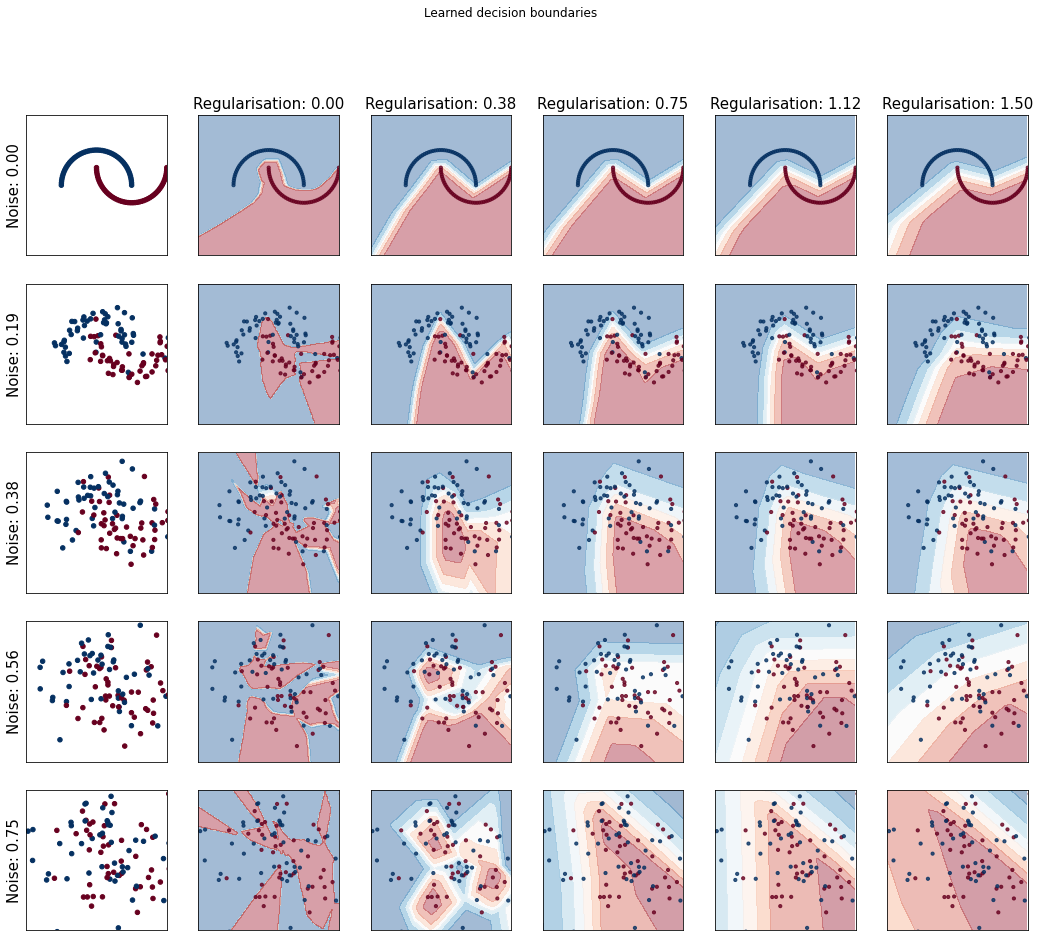

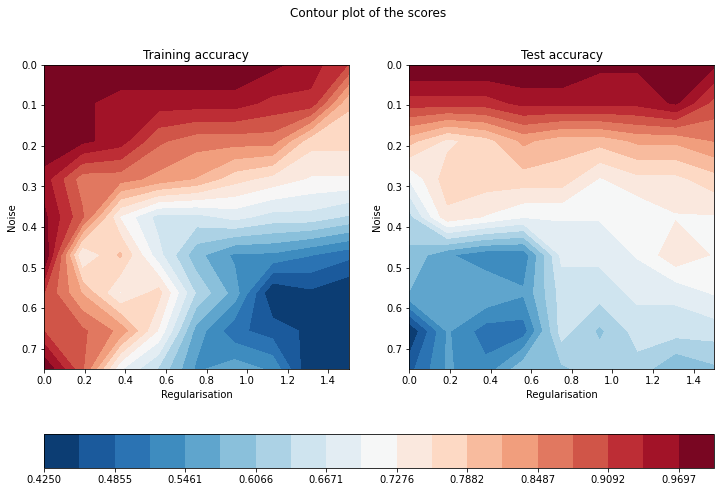

In [117]:
# Create a moon dataset with both label and data noise
datasets, noises = make_datasets(True, True, True, min_noise, max_noise, dataset_size, N)
# Train the models on every dataset and plot a selection of the resulting decision boundaries
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples)
# Plot the influence of noise and regularisation on the scores in a contour plot
score_contour_plot(noises, alphas, train_scores, test_scores)

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


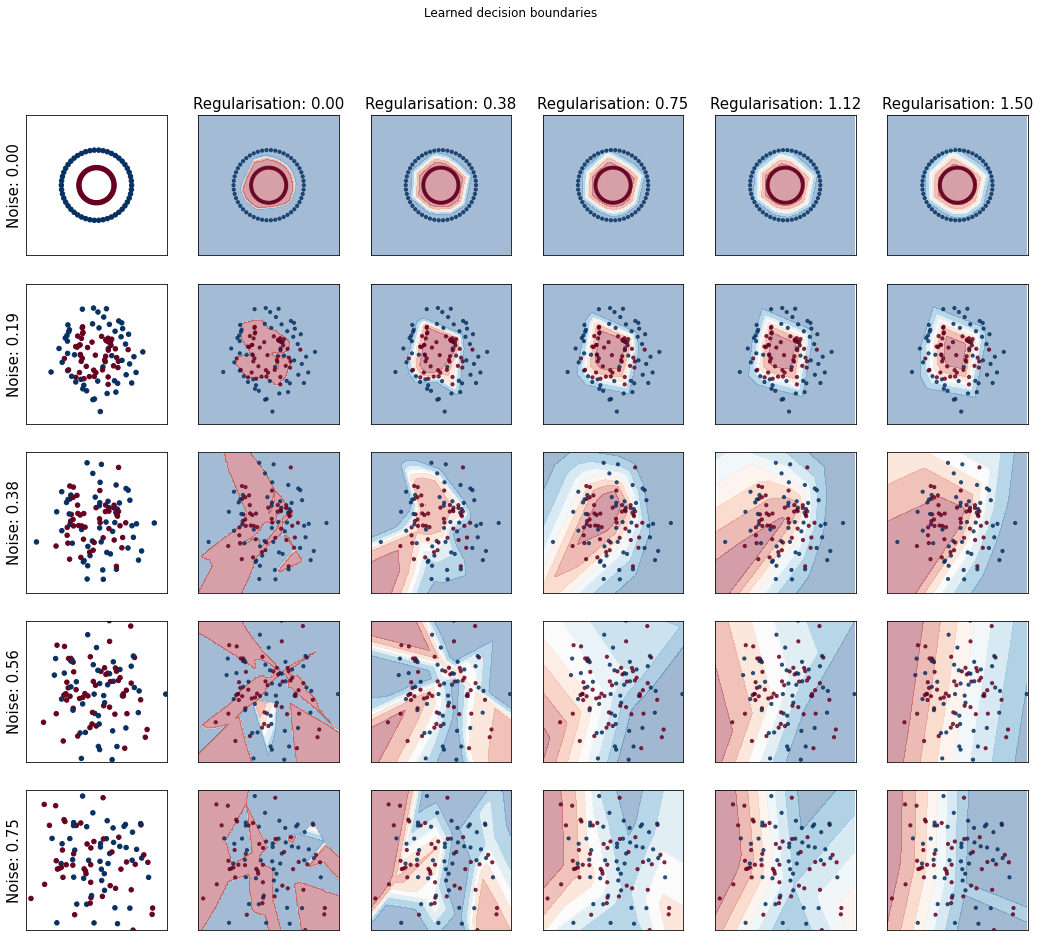

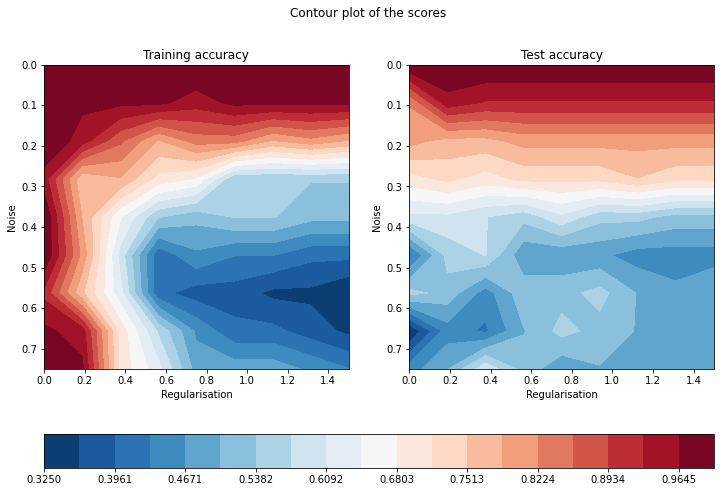

In [118]:
# Repeat the experiment for a circular dataset
datasets, noises = make_datasets(False, True, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples)
score_contour_plot(noises, alphas, train_scores, test_scores)

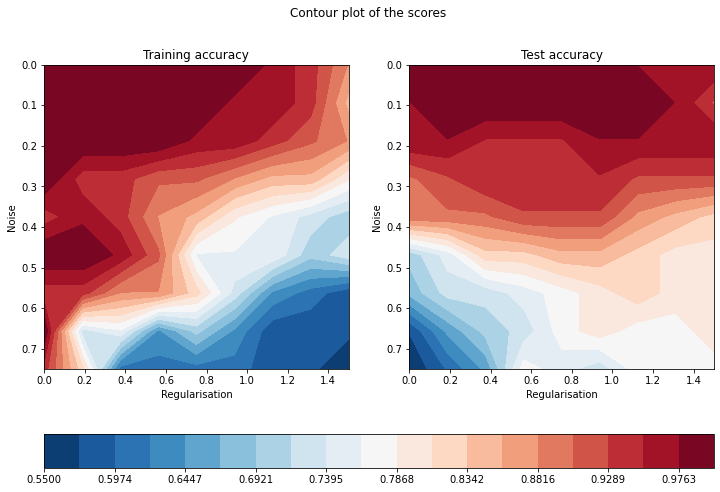

In [119]:
# Repeat the experiment for a moon dataset with only data noise
datasets, noises = make_datasets(True, True, False, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

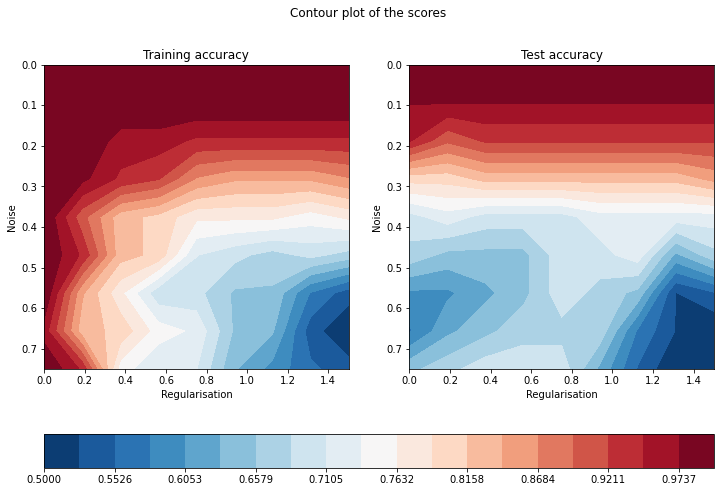

In [120]:
# Repeat the experiment for a circular dataset with only data noise
datasets, noises = make_datasets(False, True, False, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

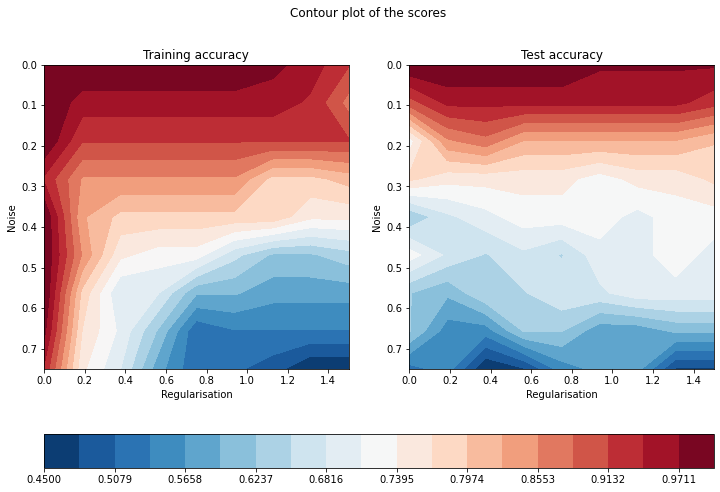

In [121]:
# Repeat the experiment for a moon dataset with only label noise
datasets, noises = make_datasets(True, False, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

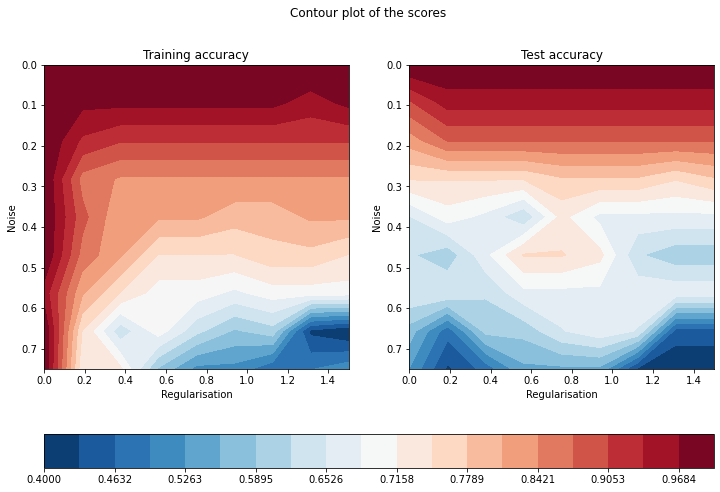

In [122]:
# Repeat the experiment for a circular dataset with only label noise
datasets, noises = make_datasets(False, False, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

## Research Question 2


## Research Question 3

## Conclusion